# DeepXDE forward solve of Lotka-Volterra System

To impose periodic output behavior in a neural network, you can add a feature layer/transformation that encodes periodicity in the data. One common way to do this is by using a sine and cosine transformation of the input. This technique is often referred to as "cyclical encoding" or "trigonometric encoding."

## Formulation

We want to solve the Lotka-Volterrra system

$$ \begin{aligned}
\frac{dr}{dt} &= \frac{R}{U}(2Ur - 0.04U^2rp), \\
\frac{dp}{dt} &= \frac{R}{U}(0.02U^2rp - 1.06Up),
\end{aligned}$$
with initial conditions
$$
r(0) = \frac{100}{U}, \quad p(0) = \frac{15}{U}.
$$

The two parameters, $U$ and $R,$ approximate the upper and right bounds of the domain, with
$$
U = 200,\quad  R = 20.
$$


## Implementation

Load packages and define parameters that will be used below for scaling the output.

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import torch

ub = 200
rb = 20

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Define the system and use `solve_ivp` from `scipy`. to generate the reference solution.

In [2]:
def func(t, r):
    x, y = r
    dx_t = 1/ub*rb*(2.0*ub*x - 0.04*ub*x*ub*y)
    dy_t = 1/ub*rb*(0.02*ub*x*ub*y - 1.06*ub*y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

Now, define the time interval and generate the test data for 3000 training residual points inside the domain,  2 points on the boundary. We use 3000 points for testing the ODE residual. 

Note that when solving this equation, we want to impose hard constraints on the initial conditions, so we define them later, when creating the network rather than as part of the PDE.

In [3]:
geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

We are now ready to define the network with 

- depth 7, 6 hidden layers of width 50.
- `tanh` activation

We transform the input data with a periodic "feature layer", $\sin kt,$  and transform the output data to impose the initial conditio,s as hard constraints.

In [4]:
layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

def input_transform(t):
    return torch.cat(
        [
            torch.sin(t),
        ],
        dim=1,
    )
# hard constraints: x(0) = 100, y(0) = 15
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

Once we have defined the neural network, we can build a Model, choose the optimizer and learning rate, and train it for 50000 iterations and plot the results.

Compiling model...
'compile' took 0.000191 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.10e+02, 1.08e+00]    [4.11e+02, 1.08e+00]    []  
1000      [3.96e+00, 4.76e-01]    [3.83e+00, 4.70e-01]    []  
2000      [2.40e+00, 5.95e-01]    [2.29e+00, 5.84e-01]    []  
3000      [1.97e+00, 6.28e-01]    [1.86e+00, 6.14e-01]    []  
4000      [1.54e+00, 6.25e-01]    [1.45e+00, 6.07e-01]    []  
5000      [1.11e+00, 5.47e-01]    [1.04e+00, 5.30e-01]    []  
6000      [6.77e-01, 4.15e-01]    [6.34e-01, 4.00e-01]    []  
7000      [3.69e-01, 2.93e-01]    [3.48e-01, 2.82e-01]    []  
8000      [1.95e-01, 2.58e-01]    [1.86e-01, 2.49e-01]    []  
9000      [1.30e-01, 1.83e-01]    [1.26e-01, 1.77e-01]    []  
10000     [9.91e-02, 1.29e-01]    [9.80e-02, 1.26e-01]    []  
11000     [6.84e-02, 1.05e-01]    [6.82e-02, 1.03e-01]    []  
12000     [7.37e-02, 9.98e-02]    [7.37e-02, 9.83e-02]    []  
13000     [7.53e-02, 8.21e-02]    [7.53e-02, 8

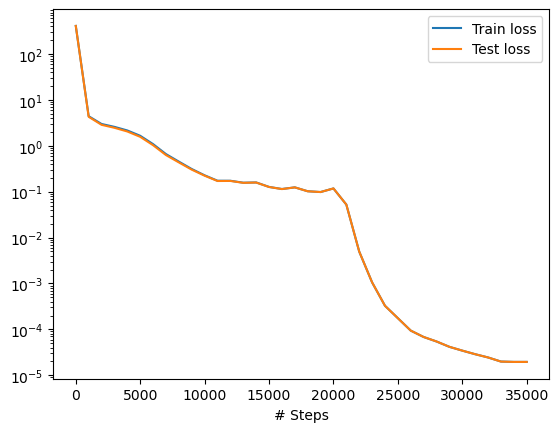

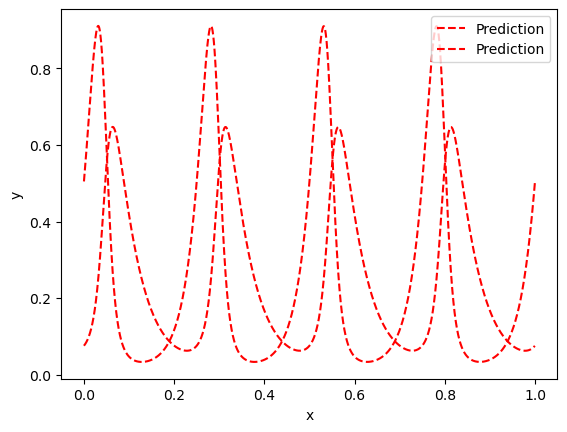

In [5]:
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=20000)
# Second fine-tuning of the solution
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Finally, we display the results.

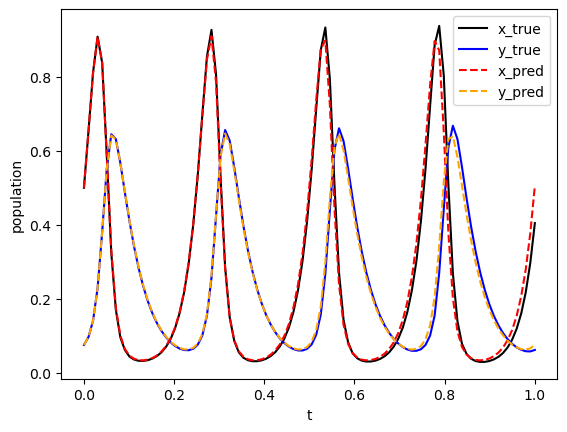

In [6]:
plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()